In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/flickr8k/train_encoded_images.p
/kaggle/input/flickr8k/model_weights.h5
/kaggle/input/flickr8k/flickr_data/Flickr_Data/flickr8ktextfiles/flickr_8k_val_dataset.txt
/kaggle/input/flickr8k/flickr_data/Flickr_Data/flickr8ktextfiles/flickr_8k_train_dataset.txt
/kaggle/input/flickr8k/flickr_data/Flickr_Data/Images/2075041394_0b3ea1822d.jpg
/kaggle/input/flickr8k/flickr_data/Flickr_Data/Images/3185662156_c877583c53.jpg
/kaggle/input/flickr8k/flickr_data/Flickr_Data/Images/2189181027_a445b13438.jpg
/kaggle/input/flickr8k/flickr_data/Flickr_Data/Images/2234910971_80e0325918.jpg
/kaggle/input/flickr8k/flickr_data/Flickr_Data/Images/3301859683_2d5e4b40a3.jpg
/kaggle/input/flickr8k/flickr_data/Flickr_Data/Images/2070831281_dc04b3e15d.jpg
/kaggle/input/flickr

In [2]:
os.listdir()

['__notebook__.ipynb']

In [3]:
# Reading the Description file

with open("../input/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt") as filepath:
    captions = filepath.read()
    filepath.close()

In [4]:
captions = captions.split("\n")[:-1]

In [5]:
len(captions)

40460

In [6]:
desc = {}

for element in captions:
    k, v = element.split("\t")
    k = k.split(".")[0]
    
    if(desc.get(k) == None):
        desc[k] = []
        
    desc[k].append(v)

In [7]:
desc["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

# Data Cleaning

In [8]:
"""
    lower order
    remove punctuation to make it easy to vectorize
    remove words with lenth less than 2
"""

def clean(text):
    text = text.lower()
    
    text = re.sub("[^a-z]", " ", text)
    
    text = text.split()
    
    text = [word for word in text if len(word)>1]
    
    text = " ".join(text)
    
    return text

In [9]:
for key, values in desc.items():
    for i in range(len(values)):
        values[i] = clean(values[i])

In [10]:
desc["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [11]:
# writing clean description to .txt file

f = open("descriptions.txt","w")
f.write( str(desc) )
f.close()

In [12]:
# creating vocab

vocab = set()

for key in desc.keys():
    [vocab.update(i.split()) for i in desc[key]]

print('Vocabulary Size: %d' % len(vocab))

Vocabulary Size: 8424


In [13]:
# all words vocab

all_vocab = []

for key in desc.keys():
    [all_vocab.append(i) for des in desc[key] for i in des.split()]
    
print('All vocab size: %d' % len(all_vocab))
print(all_vocab[:15])

All vocab size: 373837
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl']


In [14]:
#  final vocab by using threshold

import collections

counter = collections.Counter(all_vocab)

dic = dict(counter)

threshold = 10

sorted_dic = sorted(dic.items(), reverse=True, key=lambda x: x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshold]

all_vocab = [x[0] for x in sorted_dic]

In [15]:
len(all_vocab)

1845

# Train Test Data

In [16]:
#  Train images
f = open("../input/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
train = f.read()
f.close()

In [17]:
train  = [e.split(".")[0] for e in train.split("\n")[:-1]]

In [18]:
train

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87',
 '218342358_1755a9cce1',
 '2501968935_02f2cd8079',
 '2699342860_5288e203ea',
 '2638369467_8fc251595b',
 '2926786902_815a99a154',
 '2851304910_b5721199bc',
 '3423802527_94bd2b23b0',
 '3356369156_074750c6cc',
 '2294598473_40637b5c04',
 '1191338263_a4fa073154',
 '2380765956_6313d8cae3',
 '3197891333_b1b0fd1702',
 '3119887967_271a097464',
 '2276499757_b44dc6f8ce',
 '2506892928_7e79bec613',
 '2187222896_c206d63396',
 '2826769554_85c90864c9',
 '3097196395_ec06075389',
 '3603116579_4a28a932e2',
 '3339263085_6db9fd0981',
 '2532262109_87429a2cae',
 '2076906555_c20dc082db',
 '2502007071_82a8c639cf',
 '3113769557_9edbb8275c',
 '3325974730_3ee192e4ff',
 '1655781989_b15ab4cbff',
 '1662261486_db967930de',
 '2410562803_56ec09f41c',
 '2469498117_b4543e1460',
 '69710415_5c2bfb1058',
 '3414734842_beb543f400',
 '3006217970_90b42e6b27',
 '2192411521_9c7e488c5e',
 '3535879138_928

In [19]:
#  Test images
f = open("../input/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")
test = f.read()
f.close()

In [20]:
test  = [e.split(".")[0] for e in test.split("\n")[:-1]]

In [21]:
test

['3385593926_d3e9c21170',
 '2677656448_6b7e7702af',
 '311146855_0b65fdb169',
 '1258913059_07c613f7ff',
 '241347760_d44c8d3a01',
 '2654514044_a70a6e2c21',
 '2339106348_2df90aa6a9',
 '256085101_2c2617c5d0',
 '280706862_14c30d734a',
 '3072172967_630e9c69d0',
 '3482062809_3b694322c4',
 '1167669558_87a8a467d6',
 '2847615962_c330bded6e',
 '3344233740_c010378da7',
 '2435685480_a79d42e564',
 '3110649716_c17e14670e',
 '2511019188_ca71775f2d',
 '2521770311_3086ca90de',
 '2723477522_d89f5ac62b',
 '2218609886_892dcd6915',
 '3745451546_fc8ec70cbd',
 '2844018783_524b08e5aa',
 '3100251515_c68027cc22',
 '2207244634_1db1a1890b',
 '2943023421_e297f05e11',
 '3286822339_5535af6b93',
 '2479652566_8f9fac8af5',
 '1394368714_3bc7c19969',
 '872622575_ba1d3632cc',
 '2309860995_c2e2a0feeb',
 '241347204_007d83e252',
 '3502343542_f9b46688e5',
 '757332692_6866ae545c',
 '2748729903_3c7c920c4d',
 '494792770_2c5f767ac0',
 '3213992947_3f3f967a9f',
 '2295750198_6d152d7ceb',
 '2358898017_24496b80e8',
 '3222055946_45f7293

In [22]:
# create train_descriptions dictionary, which will be similar to earlier one, but having only train samples
# add startseq + endseq 

train_descriptions = {}

for t in train:
    train_descriptions[t] = []
    for cap in desc[t]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_to_append)

In [23]:
train_descriptions

{'2513260012_03d33305cf': ['startseq black dog is running after white dog in the snow endseq',
  'startseq black dog chasing brown dog through snow endseq',
  'startseq two dogs chase each other across the snowy ground endseq',
  'startseq two dogs play together in the snow endseq',
  'startseq two dogs running through low lying body of water endseq'],
 '2903617548_d3e38d7f88': ['startseq little baby plays croquet endseq',
  'startseq little girl plays croquet next to truck endseq',
  'startseq the child is playing croquette by the truck endseq',
  'startseq the kid is in front of car with put and ball endseq',
  'startseq the little boy is playing with croquet hammer and ball beside the car endseq'],
 '3338291921_fe7ae0c8f8': ['startseq brown dog in the snow has something hot pink in its mouth endseq',
  'startseq brown dog in the snow holding pink hat endseq',
  'startseq brown dog is holding pink shirt in the snow endseq',
  'startseq dog is carrying something pink in its mouth whil

# Data Preprocessing - Images

In [24]:
model = ResNet50(weights="imagenet", input_shape=(224, 224, 3))

102973440/102967424 [==============================] - 1s 0us/step


In [25]:
model_new = Model(model.input, model.layers[-2].output)

In [26]:
images = "../input/flickr8k/Flickr_Data/Flickr_Data/Images/"

In [27]:
images

'../input/flickr8k/Flickr_Data/Flickr_Data/Images/'

In [28]:
def preprocess_image(img):
    img = image.load_img(img, target_size = (224, 224))
    img = image.img_to_array(img)
    img = img.reshape(1, 224, 224, 3)
    img = preprocess_input(img)
    
    return img

In [29]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    
    return feature_vector

In [30]:
start = time()

encoding_train = {}

for ix, img in enumerate(train):
    
    img = "../input/flickr8k/Flickr_Data/Flickr_Data/Images/{}.jpg".format(train[ix])
    encoding_train[img[len(images):]] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

Encoding image- 0
Encoding image- 100
Encoding image- 200
Encoding image- 300
Encoding image- 400
Encoding image- 500
Encoding image- 600
Encoding image- 700
Encoding image- 800
Encoding image- 900
Encoding image- 1000
Encoding image- 1100
Encoding image- 1200
Encoding image- 1300
Encoding image- 1400
Encoding image- 1500
Encoding image- 1600
Encoding image- 1700
Encoding image- 1800
Encoding image- 1900
Encoding image- 2000
Encoding image- 2100
Encoding image- 2200
Encoding image- 2300
Encoding image- 2400
Encoding image- 2500
Encoding image- 2600
Encoding image- 2700
Encoding image- 2800
Encoding image- 2900
Encoding image- 3000
Encoding image- 3100
Encoding image- 3200
Encoding image- 3300
Encoding image- 3400
Encoding image- 3500
Encoding image- 3600
Encoding image- 3700
Encoding image- 3800
Encoding image- 3900
Encoding image- 4000
Encoding image- 4100
Encoding image- 4200
Encoding image- 4300
Encoding image- 4400
Encoding image- 4500
Encoding image- 4600
Encoding image- 4700
Enco

In [31]:
with open("../working/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [32]:
# TEST IMAGES

start = time()

encoding_test = {}

for ix, img in enumerate(test):
          
    img = "../input/flickr8k/Flickr_Data/Flickr_Data/Images/{}.jpg".format(test[ix])
    encoding_test[img[len(images):]] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)


Encoding image- 0
Encoding image- 100
Encoding image- 200
Encoding image- 300
Encoding image- 400
Encoding image- 500
Encoding image- 600
Encoding image- 700
Encoding image- 800
Encoding image- 900
Time taken in seconds = 53.66513776779175


In [33]:
# # Save the test ecoding to disk

with open("../working/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [34]:
with open("../working/encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [35]:
# Load the test images encoding from disk

with open("../working/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [36]:
encoding_test['3385593926_d3e9c21170.jpg'].shape

(2048,)

In [37]:
encoding_train['2513260012_03d33305cf.jpg'].shape

(2048,)


# Data Preprocessing - Captions

In [38]:
x = 1
word_to_idx = {}
idx_to_word = {}

for e in all_vocab:
    word_to_idx[e] = x
    idx_to_word[x] = e
    x +=1

In [39]:
#  need to add these 2 words as well (explicitly)
 
word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [40]:
vocab_size = len(idx_to_word)+1
print(vocab_size)

1848


In [41]:
# Max length for Caption
max_len = 0

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        curr_caption_len = len(cap.split())
        max_len = max(max_len, curr_caption_len) 

print(max_len)

35


In [42]:
with open("../working/word_to_idx.pkl", "wb") as w2i:
    pickle.dump(word_to_idx, w2i)
    
with open("../working/idx_to_word.pkl", "wb") as i2w:
    pickle.dump(idx_to_word, i2w)

# Data Prep using Generator Function

In [43]:

def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    X1, X2, y = [], [], []

    n=0

    while True:
        
        for key, desc_list in train_descriptions.items():
            n +=1

            photo = encoding_train[key+".jpg"]

            for desc in desc_list:
                
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = [], [], []
                n=0
            

In [44]:
my_gen = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, 3)

In [45]:
my_gen = iter(my_gen)

In [46]:
X, y = next(my_gen)

In [47]:
X[0].shape

(147, 2048)

In [48]:
X[1].shape

(147, 35)

In [49]:
y.shape

(147, 1848)

# Word Embedding

In [50]:
from tqdm import tqdm

In [51]:
f = open("../input/glove-global-vectors-for-word-representation/glove.6B.50d.txt", encoding='utf8')

In [52]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")
    
    embedding_index[word] = coefs
    
f.close()

# Convering words into vectors Directly - (Embedding Layer Output)

In [53]:
def get_embedding_output():
    
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
            
    return embedding_output


embedding_output = get_embedding_output()


In [54]:
embedding_output.shape

(1848, 50)

# Model Architecture

In [55]:
# image feature extractor model

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [56]:
# partial caption sequence model

input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [57]:
decoder1 = add([inp_img2 , inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge 2 networks
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

In [58]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
_______________________________________________________________________________________

In [59]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [60]:
model.compile(loss="categorical_crossentropy", optimizer="adam")


In [61]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

# Train Our Model

In [62]:
epochs = 10
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [63]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


2000/2000 [==============================] - 76s 38ms/step - loss: 2.8018


In [64]:
model.save("my_model.h5")

In [65]:
os.listdir()

['encoded_test_images.pkl',
 'my_model.h5',
 'descriptions.txt',
 'encoded_train_images.pkl',
 '__notebook__.ipynb',
 'idx_to_word.pkl',
 'word_to_idx.pkl']

# Prediction

In [66]:
def predict_caption(photo):
    """
    photo => encoding of that image (2048,)
    """
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

dog is running on the beach


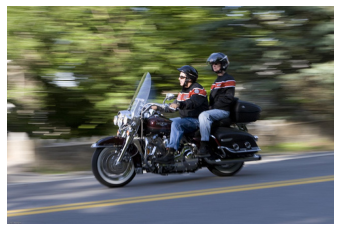

man on motorcycle rides on dirt road


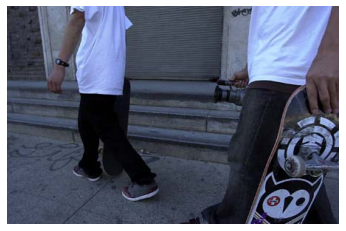

man in black shirt and black pants is standing on the sidewalk


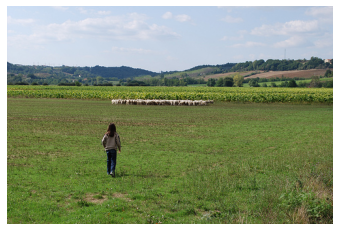

two people are walking on grassy field


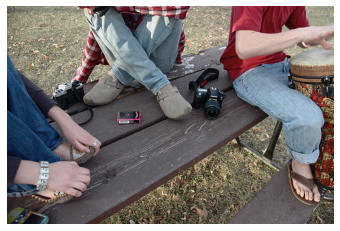

man in red shirt and leather is standing on the street


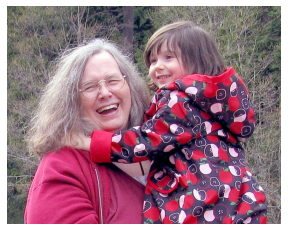

little girl in pink dress is smiling


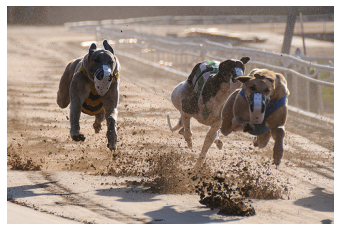

two dogs are running around track


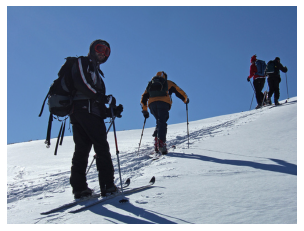

two skiers are standing in the snow


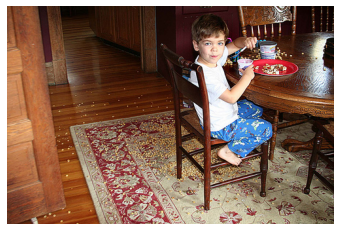

little boy is sitting on couch with his tongue sticking out


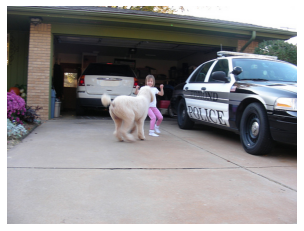

two dogs are standing in front of house


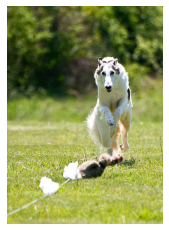

black and white dog running on field


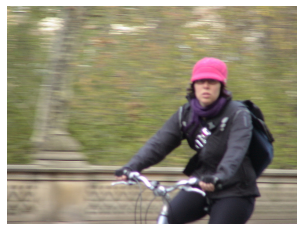

man in blue shirt and helmet is riding bicycle on the street


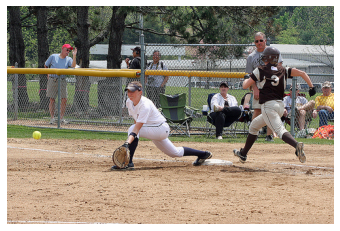

soccer player in blue uniform is running


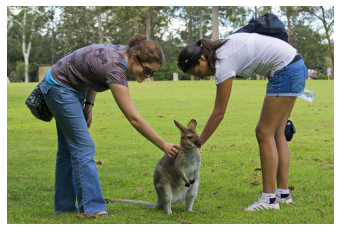

two dogs are running through field of grass


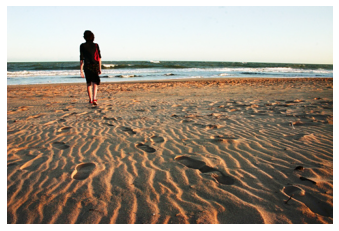

man in wetsuit is standing on beach


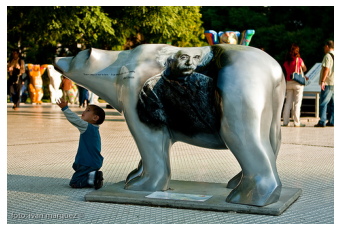

dog is standing in the middle of the lap


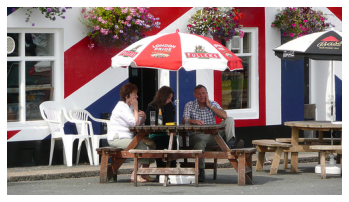

man in black shirt is sitting on bench in front of building


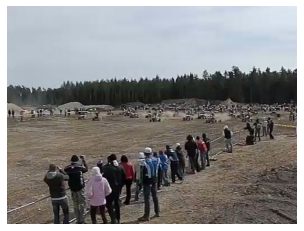

group of people are standing in the snow


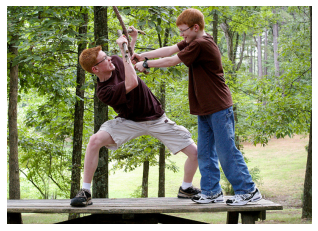

little girl in jeans crawls on the sidewalk


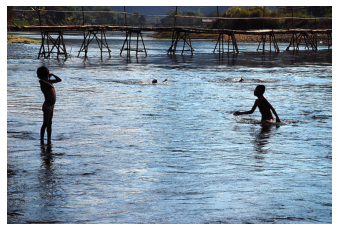

two people are playing in the water


In [67]:
for i in range(20):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(images+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)